<a href="https://colab.research.google.com/github/mocccca/cmor438/blob/main/Supervised%20Learning/Linear%20Regression/Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Linear Regression

### Introduction

Linear regression is one of the most fundamental algorithms in statistical modeling and machine learning. It models the relationship between a dependent variable (target) and one or more independent variables (predictors) by fitting a linear equation to observed data.

In simple linear regression, we fit a straight line:  
`y = β₀ + β₁x₁ + ε`  
In multiple regression, the model generalizes to:  
`y = β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ + ε`

The algorithm estimates the coefficients (β) that minimize the residual sum of squares between the observed and predicted values.



### General Process

1. **Define variables**: Choose independent (X) and dependent (y) variables.
2. **Fit the model**: Use Ordinary Least Squares (OLS) to estimate the best-fitting line.
3. **Evaluate performance**: Common metrics include:
   - R² (coefficient of determination)
   - Adjusted R²
   - Mean Absolute Error (MAE)
   - Root Mean Square Error (RMSE)
4. **Interpret coefficients**: Understand how much each predictor contributes to the outcome.



### Advantages

- Easy to interpret
- Computationally efficient
- Works well for linearly separable data
- Provides insight into variable importance
- Forms a strong baseline for comparison with more complex models



### Disadvantages

- Assumes linear relationship between variables
- Sensitive to outliers
- Struggles with multicollinearity (when predictors are highly correlated)
- May underfit complex/non-linear data



### Application to My Dataset

**Goal**: Predict depression scores (`depression_composite`) from psychological and occupational predictors.

#### Variables Used:
**Predictors**:

- `emotional_exhaution_composite`: composite score of participants' responses to 9-item scale on the Emotional Exhaustion section on Maslach Burnout Inventory (MBI; Maslach et al., 1997).
- `procrastination_composite`: composite score of participants' responses to 5-item scale on Procrastination (Tuckman et al., 1991)
- `workaholism_composite`: composite score of participants' responses to 16-item scale on Multidimensional Workaholism Scale (MWS; Clark et al., 2016).
- `neuroticism_composite`: participants' response to the neuroticism dimension of RIASEC.
- `general_js_composite`: composite score of participants' responses to 8-item scale on General Job Satisfaction (AJIG; Russell et al., 2004).
- `global_js_composite`: composite score of participants' responses to 3-item scale on Michigan Organizational Assessment Questionnaire Global Job Satisfaction (MOAQ-JSS; Cammann et al., 1983).

**Target**:
- `depression_composite`: composite score of participants' responses to 10-item scale on Center for the Epidemiological Studies of Depression Short Form (CES-D-10; Andresen et al., 1994).


In [ ]:
# Import libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import pandas_datareader as web
import plotly.express as px
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

In [ ]:
class LinearRegression:
    def __init__(self):
        self.X = None
        self.feature_names = None
        self.target_name = None
        self.y = None
        self.n_samples = None
        self.n_features = None
        self.include_bias = None
        self.coefficients = None
        self.predictions = None
        self.residuals = None

    def fit(self, X, y, include_bias=True):
        """Fit linear regression model to the data.

        Args:
            X (pd.DataFrame): Feature matrix
            y (pd.Series): Target variable
            include_bias (bool): Whether to include intercept term
        """
        self.feature_names = X.columns.tolist()
        self.target_name = y.name

        X = X.to_numpy()
        y = y.to_numpy().reshape(-1, 1)  # Ensure y is column vector

        if include_bias:
            X = np.column_stack([np.ones(X.shape[0]), X])
            self.feature_names = ['intercept'] + self.feature_names

        self.X = X
        self.y = y
        self.n_samples = X.shape[0]
        self.n_features = X.shape[1]
        self.include_bias = include_bias

        # Calculate coefficients using normal equation
        try:
            self.coefficients = np.linalg.inv(X.T @ X) @ X.T @ y
        except np.linalg.LinAlgError:
            raise ValueError("Matrix is singular. Check for multicollinearity.")

        self.predictions = X @ self.coefficients
        self.residuals = y - self.predictions

    def predict(self, X):
        """Make predictions using the fitted model.

        Args:
            X (pd.DataFrame or np.ndarray): New data to predict on

        Returns:
            np.ndarray: Predicted values
        """
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()

        if self.include_bias:
            X = np.column_stack([np.ones(X.shape[0]), X])

        return X @ self.coefficients

    def score(self, X, y):
        """Calculate R-squared score on new data.

        Args:
            X (pd.DataFrame): Feature matrix
            y (pd.Series): True target values

        Returns:
            float: R-squared score
        """
        y_pred = self.predict(X)
        y_true = y.to_numpy().reshape(-1, 1)
        ss_res = np.sum((y_true - y_pred)**2)
        ss_tot = np.sum((y_true - np.mean(y_true))**2)
        return 1 - (ss_res / ss_tot)

    def _calculate_standard_errors(self):
        """Calculate standard errors of coefficients."""
        mse = self._calculate_mse()
        cov_matrix = mse * np.linalg.inv(self.X.T @ self.X)
        return np.sqrt(np.diag(cov_matrix))

    def _calculate_mse(self):
        """Calculate mean squared error."""
        return float((self.residuals.T @ self.residuals) / (self.n_samples - self.n_features))

    def _calculate_t_stats(self):
        """Calculate t-statistics and p-values for coefficients."""
        std_errors = self._calculate_standard_errors()
        t_stats = self.coefficients.flatten() / std_errors
        p_values = [2 * (1 - stats.t.cdf(np.abs(t), self.n_samples - self.n_features))
                   for t in t_stats]
        return t_stats, p_values

    def _calculate_f_stat(self):
        """Calculate F-statistic and p-value."""
        ssr = np.sum((self.predictions - np.mean(self.y))**2)
        sse = np.sum(self.residuals**2)
        msr = ssr / (self.n_features - 1)
        mse = sse / (self.n_samples - self.n_features)
        f_stat = msr / mse
        p_value = 1 - stats.f.cdf(f_stat, self.n_features - 1, self.n_samples - self.n_features)
        return f_stat, p_value

    def model(self):
        """Print regression summary similar to statistical packages."""
        # Create coefficients table
        coef_table = pd.DataFrame({
            'Coefficient': self.coefficients.flatten(),
            'Std Error': self._calculate_standard_errors(),
            't-stat': self._calculate_t_stats()[0],
            'p-value': self._calculate_t_stats()[1]
        }, index=self.feature_names)

        # Calculate model metrics
        sse = float(self.residuals.T @ self.residuals)
        sst = float(np.sum((self.y - np.mean(self.y))**2))
        r_squared = 1 - (sse / sst)
        adj_r_squared = 1 - (1 - r_squared) * (self.n_samples - 1) / (self.n_samples - self.n_features)
        f_stat, f_p_value = self._calculate_f_stat()
        mse = self._calculate_mse()

        # Print summary
        print(f"Regression Analysis: {self.target_name} ~ {' + '.join(self.feature_names[1:])}")
        print("\nCoefficients:")
        print(coef_table.round(4))
        print(f"\nR-squared: {r_squared:.4f}, Adjusted R-squared: {adj_r_squared:.4f}")
        print(f"F-statistic: {f_stat:.2f} (p-value: {f_p_value:.4f})")
        print(f"Residual standard error: {np.sqrt(mse):.2f} on {self.n_samples - self.n_features} degrees of freedom")

    def evaluate(self, X_test, y_test):
        """Calculate key metrics on test data."""
        y_pred = self.predict(X_test)
        y_true = y_test.values if isinstance(y_test, pd.Series) else y_test

        metrics = {
            'R²': self.score(X_test, y_test),
            'Adjusted R²': 1 - (1-self.score(X_test, y_test)) * (len(y_true)-1)/(len(y_true)-X_test.shape[1]-1),
            'MAE': mean_absolute_error(y_true, y_pred),
            'MSE': mean_squared_error(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'Mean Absolute Percentage Error (MAPE)': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        }
        return pd.DataFrame(metrics, index=['Value'])

    def plot_predictions(self, X_test, y_test):
        """Plot actual vs predicted values."""
        y_pred = self.predict(X_test)
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=y_test, y=y_pred.flatten())
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Actual vs Predicted Values')

        # Add regression line to the plot
        sns.regplot(x=y_test, y=y_pred.flatten(), scatter=False, color='green')
        plt.show()

    def plot_residual_distribution(self, X_test, y_test):
        """Plot histogram and KDE of residuals."""
        y_pred = self.predict(X_test)
        residuals = y_test - y_pred.flatten()

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(residuals, kde=True)
        plt.title('Residual Distribution')

        plt.subplot(1, 2, 2)
        stats.probplot(residuals, plot=plt)
        plt.title('Q-Q Plot of Residuals')
        plt.tight_layout()
        plt.show()

    def plot_diagnostics(self):
        """Generate diagnostic plots for regression assumptions."""
        plt.figure(figsize=(15, 10))

        # Calculate standardized residuals
        std_residuals = self.residuals / np.sqrt(self._calculate_mse())

        # 1. Residuals vs Fitted
        plt.subplot(2, 2, 1)
        sns.scatterplot(x=self.predictions.flatten(), y=std_residuals.flatten())
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Residuals vs Fitted')
        plt.xlabel('Fitted values')
        plt.ylabel('Standardized Residuals')

        # 2. Q-Q Plot
        plt.subplot(2, 2, 2)
        stats.probplot(std_residuals.flatten(), plot=plt)
        plt.title('Normal Q-Q')

        # 3. Scale-Location Plot
        plt.subplot(2, 2, 3)
        sqrt_abs_resid = np.sqrt(np.abs(std_residuals))
        sns.scatterplot(x=self.predictions.flatten(), y=sqrt_abs_resid.flatten())
        plt.title('Scale-Location')
        plt.xlabel('Fitted values')
        plt.ylabel('√|Standardized Residuals|')

        # 4. Residuals vs Leverage
        plt.subplot(2, 2, 4)
        h = np.diag(self.X @ np.linalg.inv(self.X.T @ self.X) @ self.X.T)  # Leverage
        sns.scatterplot(x=h, y=std_residuals.flatten())
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Residuals vs Leverage')
        plt.xlabel('Leverage')
        plt.ylabel('Standardized Residuals')

        plt.tight_layout()
        plt.show()


# ***applying to my data***

In [ ]:
url = "https://raw.githubusercontent.com/mocccca/cmor438/main/Leisure_Intereset_Dataset.csv"
li = pd.read_csv(url)
li1 = li[['depression_composite', 'emotional_exhaution_composite', 'procrastination_composite']]
li1

,depression_composite,emotional_exhaution_composite,procrastination_composite
0,16,35,14
1,17,31,5
2,8,14,16
3,23,58,19
4,23,39,15
...,...,...,...
116,11,22,5
117,6,13,9
118,12,33,10
119,14,31,5


In [ ]:
# Select features and target
features = ['emotional_exhaution_composite', 'procrastination_composite']
target = 'depression_composite'

# Split into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    li1[features], li1[target], test_size=0.2, random_state=42
)

# Standardize features (important for regularization if you add it later)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for our custom class
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features)

In [ ]:
# Initialize and fit the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Print model summary
model.model()

# Evaluate on test set
test_r2 = model.score(X_test_scaled, y_test)
print(f"\nTest R-squared: {test_r2:.4f}")

Regression Analysis: depression_composite ~ emotional_exhaution_composite + procrastination_composite

Coefficients:
                               Coefficient  Std Error   t-stat  p-value
intercept                          14.2396     0.4479  31.7885   0.0000
emotional_exhaution_composite       2.0939     0.4740   4.4171   0.0000
procrastination_composite           1.5607     0.4740   3.2924   0.0014

R-squared: 0.3244, Adjusted R-squared: 0.3098
F-statistic: 22.32 (p-value: 0.0000)
Residual standard error: 4.39 on 93 degrees of freedom

Test R-squared: 0.4856


<ipython-input-3-6271a7844b81>:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float((self.residuals.T @ self.residuals) / (self.n_samples - self.n_features))
<ipython-input-3-6271a7844b81>:119: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sse = float(self.residuals.T @ self.residuals)


Test Set Performance:
             R²  Adjusted R²       MAE        MSE      RMSE  \
Value  0.485608     0.438845  3.161429  15.296792  3.911111   

       Mean Absolute Percentage Error (MAPE)  
Value                              52.497341  


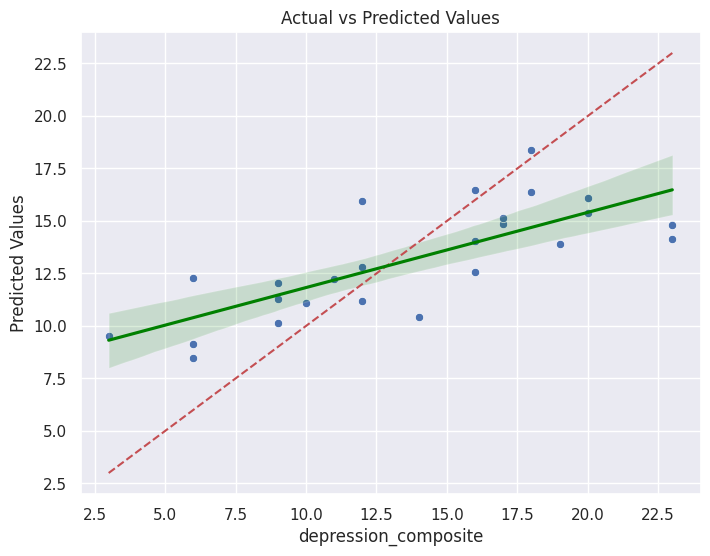

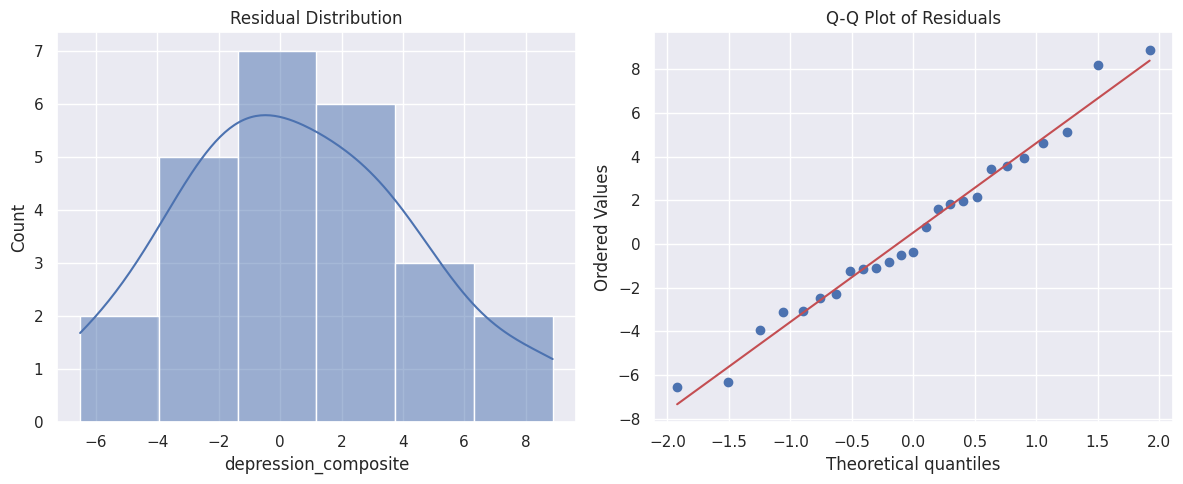

<ipython-input-3-6271a7844b81>:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float((self.residuals.T @ self.residuals) / (self.n_samples - self.n_features))


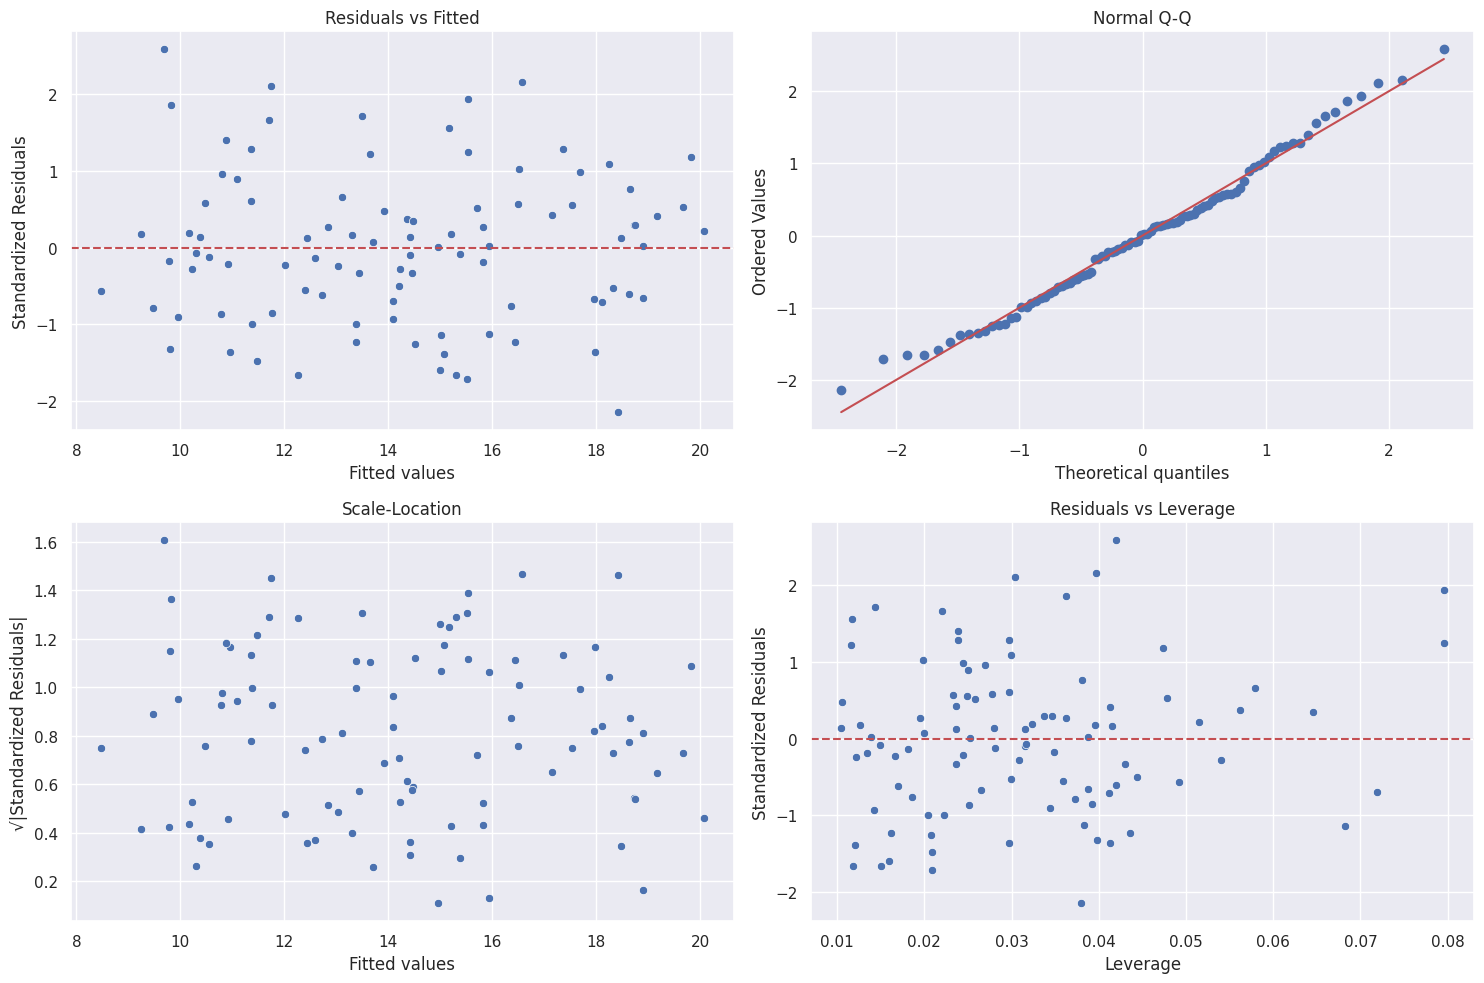

In [ ]:
# After model training
model = LinearRegression()
model.fit(X_train, y_train)

# 1. Get metrics
print("Test Set Performance:")
print(model.evaluate(X_test, y_test))

# 2. Visualize predictions
model.plot_predictions(X_test, y_test)

# 3. Check residuals
model.plot_residual_distribution(X_test, y_test)

# 4. Diagnostic plots
model.plot_diagnostics()

let's increase the covariates into the model

In [ ]:
li2 = li[['depression_composite', 'emotional_exhaution_composite', 'procrastination_composite', 'workaholism_composite', 'neuroticism_composite', 'general_js_composite', 'global_js_composite']]
li2
# Select features and target
features1 = ['emotional_exhaution_composite', 'procrastination_composite', 'workaholism_composite', 'neuroticism_composite', 'general_js_composite', 'global_js_composite']
target1 = 'depression_composite'

# Split into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    li2[features1], li2[target1], test_size=0.2, random_state=42
)

# Standardize features (important for regularization if you add it later)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for our custom class
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features1)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features1)

In [ ]:
# Initialize and fit the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Print model summary
model.model()

# Evaluate on test set
test_r2 = model.score(X_test_scaled, y_test)
print(f"\nTest R-squared: {test_r2:.4f}")

Regression Analysis: depression_composite ~ emotional_exhaution_composite + procrastination_composite + workaholism_composite + neuroticism_composite + general_js_composite + global_js_composite

Coefficients:
                               Coefficient  Std Error   t-stat  p-value
intercept                          14.2396     0.4309  33.0426   0.0000
emotional_exhaution_composite       1.9459     0.5197   3.7444   0.0003
procrastination_composite           1.6263     0.4741   3.4304   0.0009
workaholism_composite               0.5501     0.4698   1.1710   0.2447
neuroticism_composite               0.9263     0.4687   1.9764   0.0512
general_js_composite                0.7609     0.5608   1.3567   0.1783
global_js_composite                -1.0558     0.5022  -2.1025   0.0383

R-squared: 0.4016, Adjusted R-squared: 0.3612
F-statistic: 9.95 (p-value: 0.0000)
Residual standard error: 4.22 on 89 degrees of freedom

Test R-squared: 0.5423


<ipython-input-3-6271a7844b81>:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float((self.residuals.T @ self.residuals) / (self.n_samples - self.n_features))
<ipython-input-3-6271a7844b81>:119: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sse = float(self.residuals.T @ self.residuals)


Test Set Performance:
             R²  Adjusted R²       MAE        MSE     RMSE  \
Value  0.542281     0.389709  2.774948  13.611453  3.68937   

       Mean Absolute Percentage Error (MAPE)  
Value                              53.846817  


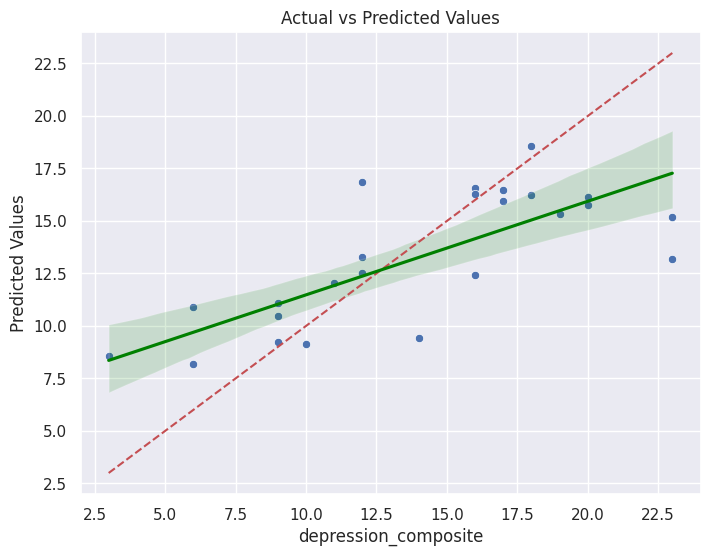

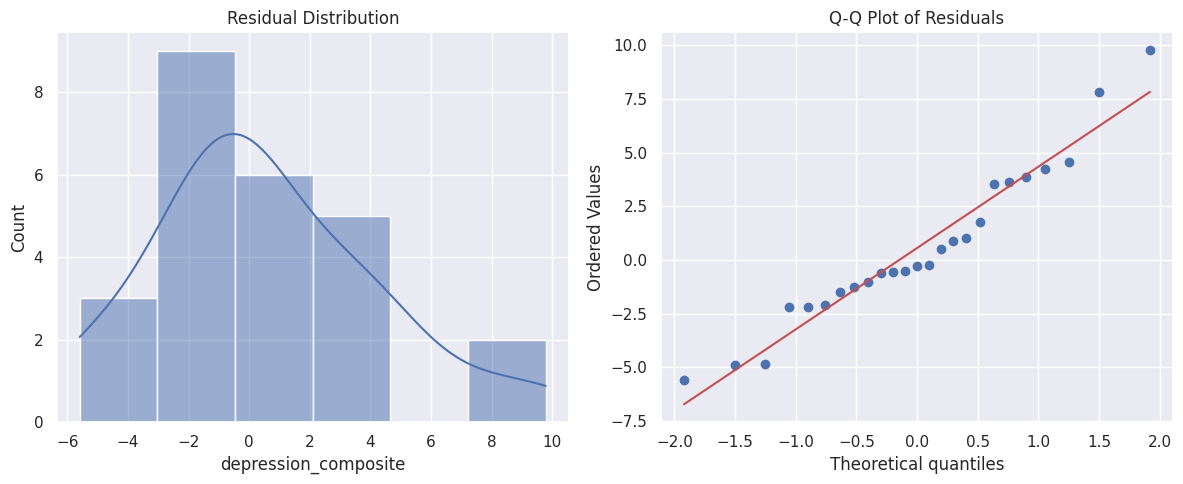

<ipython-input-3-6271a7844b81>:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float((self.residuals.T @ self.residuals) / (self.n_samples - self.n_features))


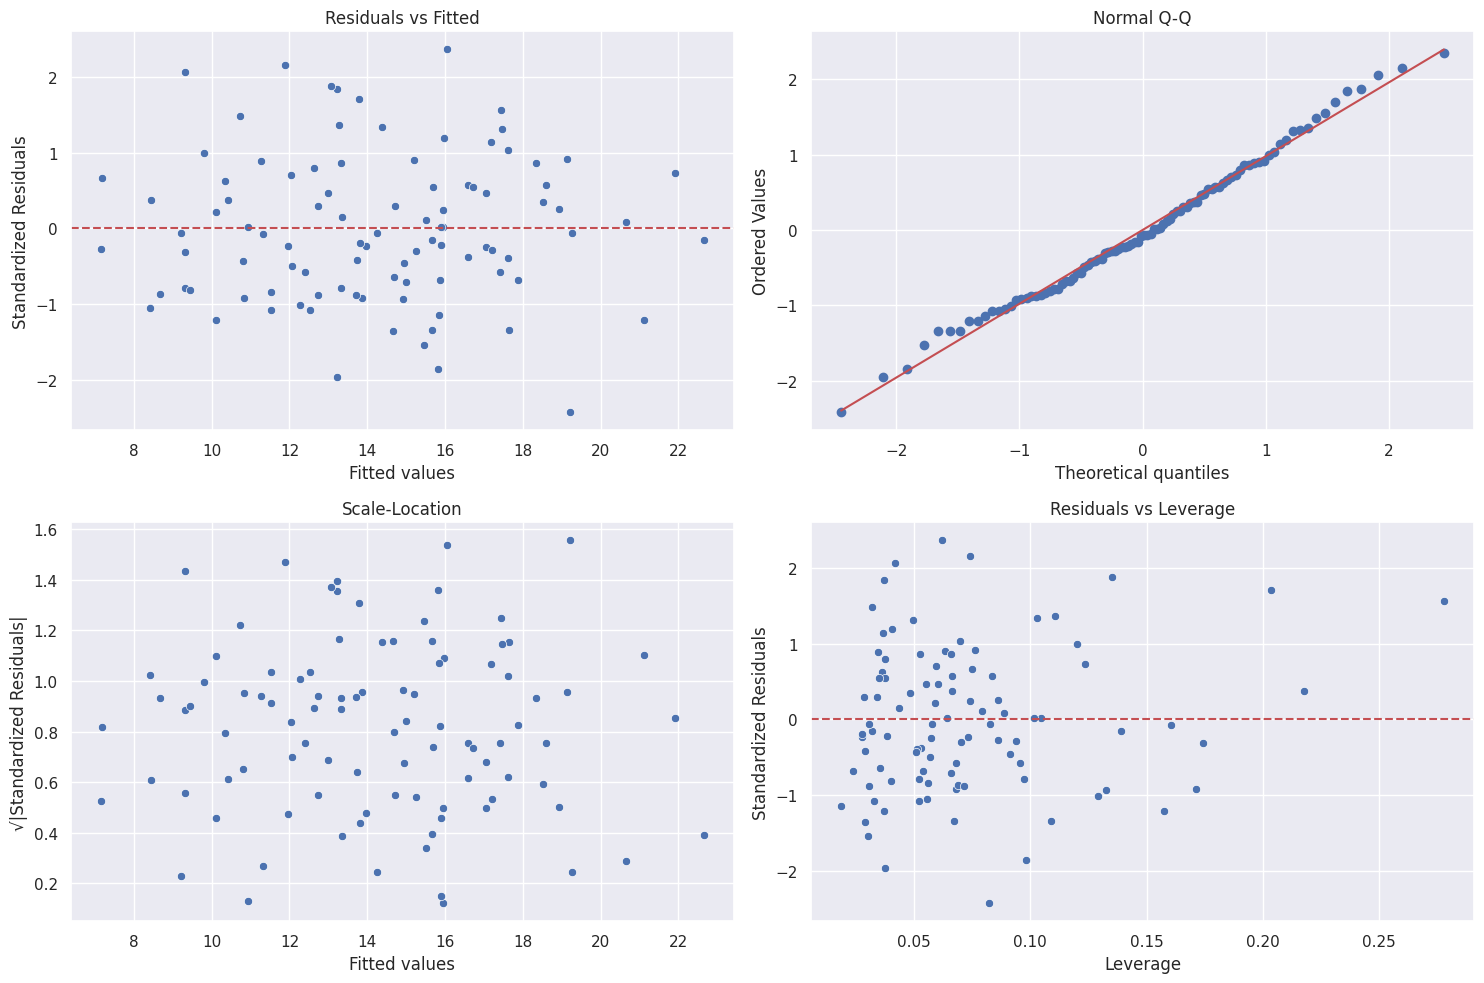

In [ ]:
# After model training
model = LinearRegression()
model.fit(X_train, y_train)

# 1. Get metrics
print("Test Set Performance:")
print(model.evaluate(X_test, y_test))

# 2. Visualize predictions
model.plot_predictions(X_test, y_test)

# 3. Check residuals
model.plot_residual_distribution(X_test, y_test)

# 4. Diagnostic plots
model.plot_diagnostics()

let's delete the covariates that's not providing significant results

In [ ]:
li2 = li[['depression_composite', 'emotional_exhaution_composite', 'procrastination_composite', 'workaholism_composite', 'neuroticism_composite']]
li2
# Select features and target
features1 = ['emotional_exhaution_composite', 'procrastination_composite', 'workaholism_composite', 'neuroticism_composite']
target1 = 'depression_composite'

# Split into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    li2[features1], li2[target1], test_size=0.2, random_state=42
)

# Standardize features (important for regularization if you add it later)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for our custom class
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features1)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features1)

In [ ]:
# Initialize and fit the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Print model summary
model.model()

# Evaluate on test set
test_r2 = model.score(X_test_scaled, y_test)
print(f"\nTest R-squared: {test_r2:.4f}")

Regression Analysis: depression_composite ~ emotional_exhaution_composite + procrastination_composite + workaholism_composite + neuroticism_composite

Coefficients:
                               Coefficient  Std Error   t-stat  p-value
intercept                          14.2396     0.4377  32.5294   0.0000
emotional_exhaution_composite       1.9746     0.4668   4.2305   0.0001
procrastination_composite           1.5567     0.4762   3.2694   0.0015
workaholism_composite               0.6351     0.4558   1.3933   0.1669
neuroticism_composite               0.7970     0.4609   1.7293   0.0871

R-squared: 0.3687, Adjusted R-squared: 0.3409
F-statistic: 13.28 (p-value: 0.0000)
Residual standard error: 4.29 on 91 degrees of freedom

Test R-squared: 0.5605


<ipython-input-3-6271a7844b81>:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float((self.residuals.T @ self.residuals) / (self.n_samples - self.n_features))
<ipython-input-3-6271a7844b81>:119: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sse = float(self.residuals.T @ self.residuals)


Test Set Performance:
            R²  Adjusted R²       MAE        MSE      RMSE  \
Value  0.56053     0.472636  2.769161  13.068788  3.615078   

       Mean Absolute Percentage Error (MAPE)  
Value                              53.078734  


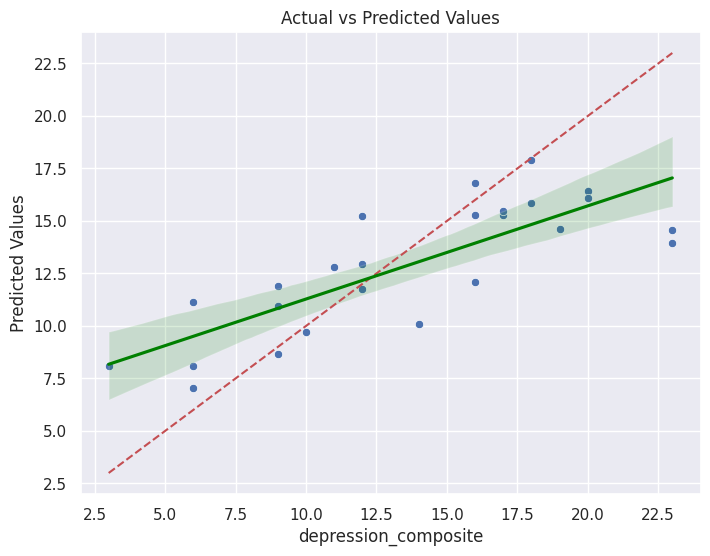

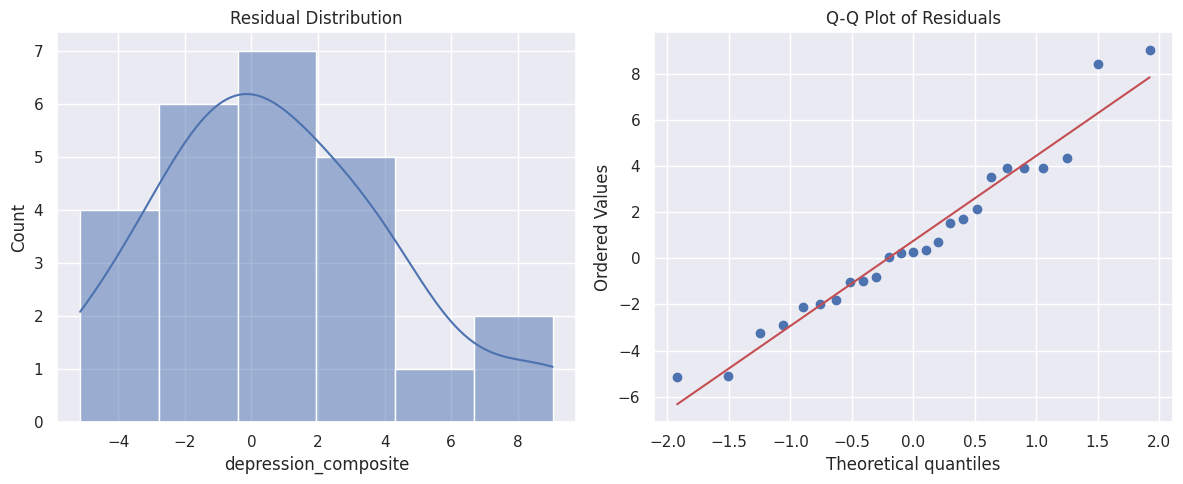

<ipython-input-3-6271a7844b81>:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float((self.residuals.T @ self.residuals) / (self.n_samples - self.n_features))


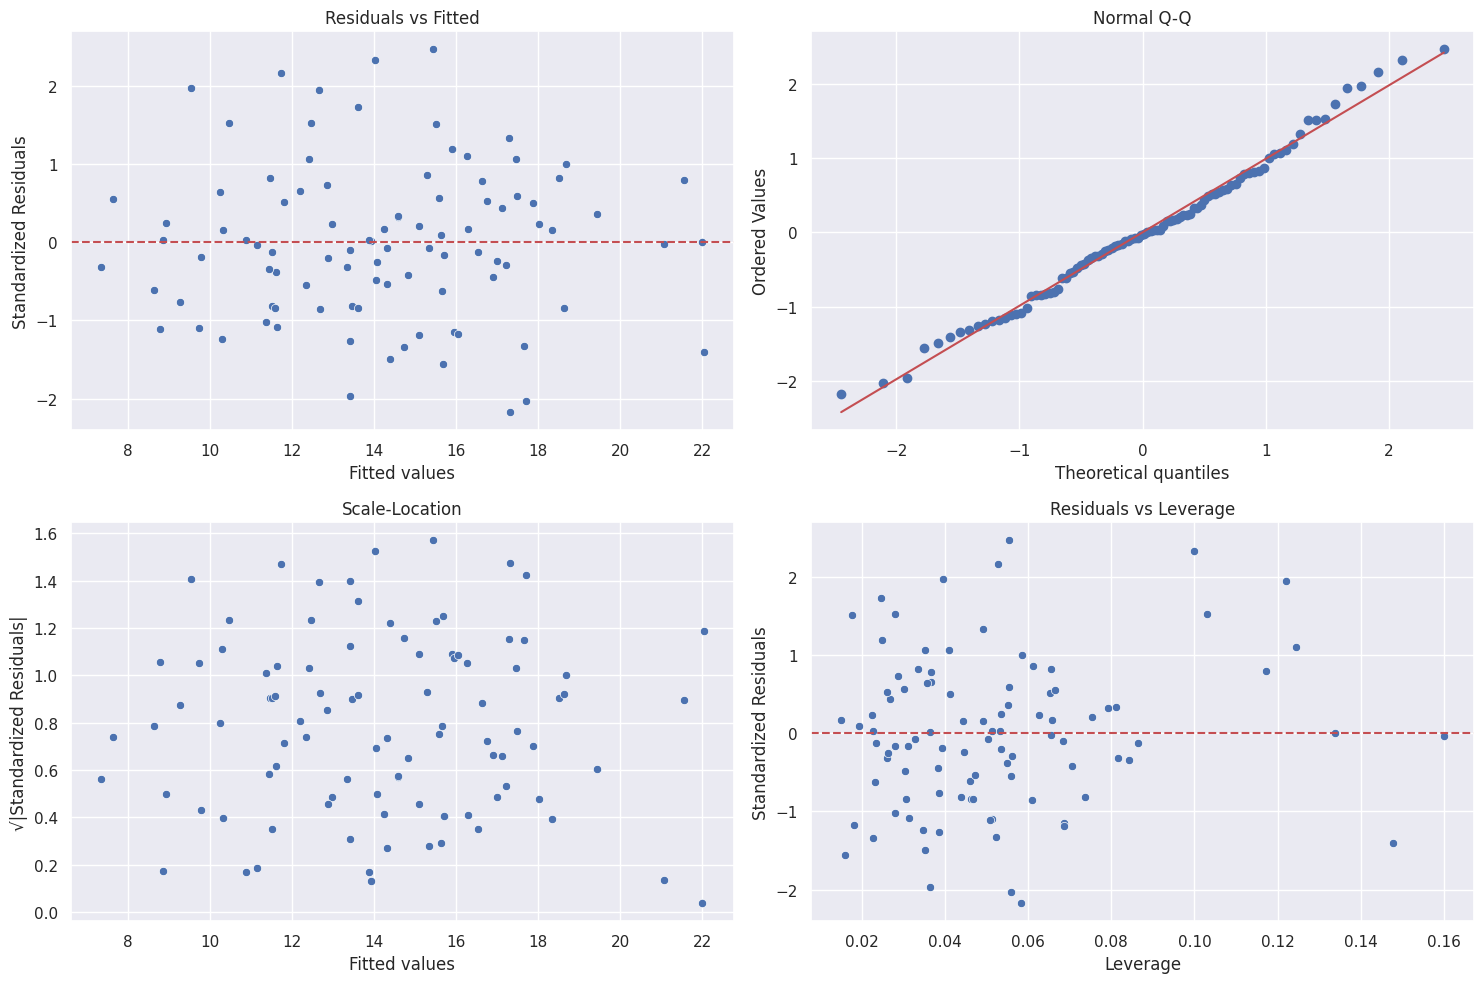

In [ ]:
# After model training
model = LinearRegression()
model.fit(X_train, y_train)

# 1. Get metrics
print("Test Set Performance:")
print(model.evaluate(X_test, y_test))

# 2. Visualize predictions
model.plot_predictions(X_test, y_test)

# 3. Check residuals
model.plot_residual_distribution(X_test, y_test)

# 4. Diagnostic plots
model.plot_diagnostics()

**Model Evolution & Performance**

*Original 2-Predictor Model*

(Emotional exhaustion + Procrastination)



*   R²: 0.486 – Explained ~49% of depression variance
*   Baseline for comparing expansions

*First Expansion (6 Predictors)*

(Added workaholism, neuroticism, general/global job satisfaction)

*   R²: 0.542 – Improved slightly (+5.6%)
*   Adjusted R² dropped to 0.390
*   Suggested redundancy (likely between job satisfaction variables)
*   Minimal error reduction (e.g., RMSE: 3.91 → 3.69)

*Refined 4-Predictor Model*

(Kept workaholism + neuroticism; removed job satisfaction)

*   R²: 0.561 – Best performance (+7.5% over baseline)
*   Adjusted R²: 0.473 – Confirmed non-redundant predictors
*   Lower errors (MAE: 2.77 vs. original 3.16; RMSE: 3.62 vs. 3.91)

**Key Insights**

Neuroticism and workaholism added value: These variables captured unique variance in depression beyond emotional exhaustion/procrastination, aligning with psychological theory (e.g., neuroticism as a core depression risk factor).

Job satisfaction variables were redundant: They likely overlapped with other predictors or were less directly tied to depression. Removing them improved model efficiency.

Linear regression worked well: The consistent R² improvements and stable error metrics suggest linear relationships were appropriate for the data. However, the 52-53% MAPE indicates room for improvement—potentially from:

*   Non-linear terms (e.g., interactions between neuroticism and workaholism)

*   Other algorithms (e.g., Random Forest to capture complex patterns)




The refined 4-predictor model strikes the best balance between simplicity and explanatory power. While linear regression provided interpretable results, exploring non-linear methods could further reduce prediction errors.